# CSS 444 Final Project

### Michael Cho

# Baltimore, MD Arrest Records 12/31/2009 - 10/22/2021

This dataset is all arrest records in Baltimore, MD from 12/31/2009 to 10/22/2021. We found this dataset on the [Police Data Initiative](https://www.policedatainitiative.org/datasets/) database website, which contains various types of datasets from police jurisdictions across the United States. 

[Open Baltimore Arrest Dataset](https://data.baltimorecity.gov/datasets/baltimore::arrests/about)

In [1]:
# Importing required Python Libraries

import pandas as pd
from matplotlib import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from statsmodels.stats import proportion
import datetime
from itertools import product
import csv

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

# Code to display whole dataframe with print
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
# Data set file path
data_url = '/Users/michaelcho/_GoogleDrive/_Classes/CSS 444 A/Final_Project/data/Arrests.csv'

In [3]:
# Loading dataset into pd DataFrame
data = pd.read_csv(data_url)

# Descriptive Analysis

In [4]:
# Splitting dataset into train and test 80/20 split
# For use in later analyses
train_data = data.sample(frac=0.8, random_state=25)
test_data = data.drop(train_data.index)

num_train = len(train_data)

# Printing number of training points
print(f"No. of training points: {train_data.shape[0]}")
print(f"No. of testing points: {test_data.shape[0]}")

# Combining train and test data for descriptive analysis
# Removing NaN rows for Gender
original = pd.concat([train_data, test_data])
original = original[original['Gender'].notna()]

original.head()

No. of training points: 281255
No. of testing points: 70314


,X,Y,RowID,ArrestNumber,Age,Gender,Race,ArrestDateTime,ArrestLocation,IncidentOffence,IncidentLocation,Charge,ChargeDescription,District,Post,Neighborhood,Latitude,Longitude,GeoLocation,Shape
171271,1.423933e+06,591809.446923,171272,12505619.0,55.0,M,B,2012/06/29 11:15:00+00,800 FAYETTE ST,87NARCOTICS,800 FAYETTE ST,4 3550,CDS VIOL,Southeast,211,Jonestown,39.2910,-76.6057,"(39.291,-76.6057)",NaN
346948,1.442387e+06,586213.654760,346949,10000971.0,24.0,M,B,2010/01/06 09:15:00+00,1500 CHARLOTTE AV,3KROBB RES. (UA),1500 CHARLOTTE AV,NaN,Unknown Charge,Southeast,234,Broening Manor,39.2754,-76.5406,"(39.2754,-76.5406)",NaN
10906,1.416643e+06,581908.237423,10907,15188371.0,26.0,M,B,2015/12/16 10:30:00+00,2200 CEDLEY ST,87NARCOTICS,2200 CEDLEY ST,4 3550,CDS,Southern,921,Westport,39.2639,-76.6316,"(39.2639,-76.6316)",NaN
218363,NaN,NaN,218364,14076816.0,23.0,F,W,2014/05/12 15:00:00+00,NaN,Unknown Offense,NaN,1 0088,VIOLATION OF PROBATION,NaN,NaN,NaN,NaN,NaN,"(,)",NaN
341962,NaN,NaN,341963,22003143.0,30.0,M,B,2022/01/10 07:00:00+00,NaN,Unknown Offense,NaN,1 0077,FAILURE TO APPEAR,NaN,NaN,NaN,NaN,NaN,"(,)",NaN


In [5]:
# Printing row count for female and male
print("Total Female: " + str(original['Gender'].value_counts().F))
print("Total Male: " + str(original['Gender'].value_counts().M))

# Percentage of total female and male data points
print("Percentage Female: " + str((original['Gender'].value_counts().F/len(original))))
print("Percentage Male: " + str((original['Gender'].value_counts().M/len(original))))

Total Female: 65151
Total Male: 286379
Percentage Female: 0.18533553324040622
Percentage Male: 0.8146644667595938


In [6]:
# Subsetting black and white races
black = original[original['Race']=='B'] 
white = original[original['Race']=='W']

# Counting number of black and white datapoints
total_black = len(original[original['Race']=='B'])
total_white = len(original[original['Race']=='W'])

# Print totals
print(total_black)
print(total_white)

# Percentage of black female and male
black_female = len(black[(black.Gender == 'F') | (black.Gender == 'F')])/total_black
black_male = len(black[(black.Gender == 'M') | (black.Gender == 'M')])/total_black

# Percentage of white female and male
white_female = len(white[(white.Gender == 'F') | (white.Gender == 'F')])/total_white
white_male = len(white[(white.Gender == 'M') | (white.Gender == 'M')])/total_white

# Create table
target_percent = pd.DataFrame({'F': [black_female, white_female], 'M': [black_male, white_male]}, index=['Black', 'White'])
target_percent

290485
52200


,F,M
Black,0.162604,0.837396
White,0.320613,0.679387


# Logistic Regression

In [7]:
# Creating a Binary Target Variable
# In this case, whether the arrested person is male
is_male = original['Gender']
is_male = is_male.replace('M', 1).replace('F', 0)

In [8]:
# Using race as the only feature
data_race = original['Race']
data_race.head()

171271    B
346948    B
10906     B
218363    W
341962    B
Name: Race, dtype: object

In [9]:
# Function for normalizing data
def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

#see here for transformation : https://developers.google.com/machine-learning/data-prep/transform/normalization

In [10]:
# Data normalized
data = data_transform(data_race)

# Labels changed
data = data.rename(columns={"A": "Asian", "B": "Black", "H": "Hispanic", "I": "NativeAmerican", "U": "Unknown", "W": "White"})
data.head()

,Asian,Black,Hispanic,NativeAmerican,Unknown,White
0,-0.051614,0.458420,-0.001687,-0.048531,-0.14341,-0.417600
1,-0.051614,0.458420,-0.001687,-0.048531,-0.14341,-0.417600
2,-0.051614,0.458420,-0.001687,-0.048531,-0.14341,-0.417600
3,-0.051614,-2.181408,-0.001687,-0.048531,-0.14341,2.394638
4,-0.051614,0.458420,-0.001687,-0.048531,-0.14341,-0.417600


In [11]:
# Logistic Regression Functions
cls_male = linear_model.LogisticRegression()
cls_male.fit(data,is_male)

# Printing coefficients for race
print(cls_male.coef_)

[[ 0.00682599  0.1366492   0.00974089  0.02142998  0.09607215 -0.18749153]]


In [12]:
from sklearn.metrics import mean_squared_error
res_male=cls_male.predict(data)

# Standard error measurement
print(mean_squared_error(is_male,res_male))

0.18533553324040622


### Data Analysis

In [13]:
original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351530 entries, 171271 to 351564
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   X                  220720 non-null  float64
 1   Y                  220720 non-null  float64
 2   RowID              351530 non-null  int64  
 3   ArrestNumber       335352 non-null  float64
 4   Age                351433 non-null  float64
 5   Gender             351530 non-null  object 
 6   Race               351530 non-null  object 
 7   ArrestDateTime     351530 non-null  object 
 8   ArrestLocation     225168 non-null  object 
 9   IncidentOffence    351530 non-null  object 
 10  IncidentLocation   225168 non-null  object 
 11  Charge             305098 non-null  object 
 12  ChargeDescription  351530 non-null  object 
 13  District           220215 non-null  object 
 14  Post               220215 non-null  object 
 15  Neighborhood       220167 non-null  object 
 1

In [14]:
original.isnull().sum()

X                    130810
Y                    130810
RowID                     0
ArrestNumber          16178
Age                      97
Gender                    0
Race                      0
ArrestDateTime            0
ArrestLocation       126362
IncidentOffence           0
IncidentLocation     126362
Charge                46432
ChargeDescription         0
District             131315
Post                 131315
Neighborhood         131363
Latitude             130810
Longitude            130810
GeoLocation               0
Shape                351530
dtype: int64

In [15]:
original.describe()

,X,Y,RowID,ArrestNumber,Age,Latitude,Longitude,Shape
count,2.207200e+05,220720.000000,351530.000000,3.353520e+05,351433.000000,220720.000000,220720.000000,0.0
mean,1.428920e+06,596004.514451,175799.238972,1.442050e+07,33.177490,39.292232,-76.597341,NaN
std,5.260441e+05,28308.172841,101483.627499,3.191930e+06,11.627969,0.674935,1.315299,NaN
min,-1.720966e+00,-948896.130248,1.000000,1.000001e+07,8.000000,0.000000,-81.529200,NaN
25%,1.411959e+06,591367.022798,87916.250000,1.138570e+07,24.000000,39.289800,-76.648000,NaN
50%,1.420058e+06,595568.285798,175798.500000,1.401481e+07,30.000000,39.301400,-76.619400,NaN
75%,1.428231e+06,601471.708430,263686.750000,1.703344e+07,42.000000,39.317500,-76.590500,NaN
max,3.207084e+07,703474.347998,351569.000000,9.990540e+07,100.000000,39.598000,0.000000,NaN


In [16]:
# We want to avvoid the columns that contain lots of nan value
# only use the key features (Age, Gender, Race) and features with no nan value
feature = {
            "Row ID" : original['RowID'],
            "Age" : original['Age'], 
            "Gender" : original['Gender'],
            "Race" : original['Race'],
            "Arrest_Time" : original['ArrestDateTime'],
            "Incident_Offence" : original['IncidentOffence'],
            "Charge_Description" : original['ChargeDescription']
          }
marginal = pd.DataFrame(data=feature, columns=['Row ID', 'Age', 'Gender', 'Race', 'Arrest_Time', 'Incident_Offence', 'Charge_Description'])
marginal.head()

,Row ID,Age,Gender,Race,Arrest_Time,Incident_Offence,Charge_Description
171271,171272,55.0,M,B,2012/06/29 11:15:00+00,87NARCOTICS,CDS VIOL
346948,346949,24.0,M,B,2010/01/06 09:15:00+00,3KROBB RES. (UA),Unknown Charge
10906,10907,26.0,M,B,2015/12/16 10:30:00+00,87NARCOTICS,CDS
218363,218364,23.0,F,W,2014/05/12 15:00:00+00,Unknown Offense,VIOLATION OF PROBATION
341962,341963,30.0,M,B,2022/01/10 07:00:00+00,Unknown Offense,FAILURE TO APPEAR


In [17]:
#Prints information of all columns:
print("Marginal Data information:")
marginal.info()

# Number of Nan data
print("\n\nMarginal Data Size: ", len(marginal))
print("\n\nNumber of nan data: ")
marginal.isnull().sum()

Marginal Data information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 351530 entries, 171271 to 351564
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Row ID              351530 non-null  int64  
 1   Age                 351433 non-null  float64
 2   Gender              351530 non-null  object 
 3   Race                351530 non-null  object 
 4   Arrest_Time         351530 non-null  object 
 5   Incident_Offence    351530 non-null  object 
 6   Charge_Description  351530 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 21.5+ MB


Marginal Data Size:  351530


Number of nan data: 


Row ID                 0
Age                   97
Gender                 0
Race                   0
Arrest_Time            0
Incident_Offence       0
Charge_Description     0
dtype: int64

In [18]:
#Drop rows with Nan value
marginal.dropna(subset = ['Age'], inplace=True)

In [19]:
print("Marginal data size after drop rows with Nan value: ", len(marginal))
print("\nNumber of nan data: ")
# Number of Nan data
marginal.isnull().sum()

Marginal data size after drop rows with Nan value:  351433

Number of nan data: 


Row ID                0
Age                   0
Gender                0
Race                  0
Arrest_Time           0
Incident_Offence      0
Charge_Description    0
dtype: int64

In [20]:
marginal.head()

,Row ID,Age,Gender,Race,Arrest_Time,Incident_Offence,Charge_Description
171271,171272,55.0,M,B,2012/06/29 11:15:00+00,87NARCOTICS,CDS VIOL
346948,346949,24.0,M,B,2010/01/06 09:15:00+00,3KROBB RES. (UA),Unknown Charge
10906,10907,26.0,M,B,2015/12/16 10:30:00+00,87NARCOTICS,CDS
218363,218364,23.0,F,W,2014/05/12 15:00:00+00,Unknown Offense,VIOLATION OF PROBATION
341962,341963,30.0,M,B,2022/01/10 07:00:00+00,Unknown Offense,FAILURE TO APPEAR


In [21]:
marginal.describe()

,Row ID,Age
count,351433.000000,351433.000000
mean,175795.804424,33.177490
std,101485.176576,11.627969
min,1.000000,8.000000
25%,87908.000000,24.000000
50%,175788.000000,30.000000
75%,263688.000000,42.000000
max,351569.000000,100.000000


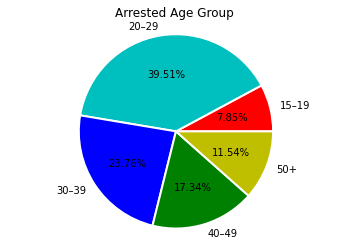

In [22]:
# Subgroup with age under 15, 15–19, 20–29, 30–39, 40–49, and 50+
age_group = marginal['Age']

young = marginal[age_group < 15]
teen = marginal[age_group.between(15,19)]
twenties = marginal[age_group.between(20,29)]
thirties = marginal[age_group.between(30,39)]
forties =marginal[age_group.between(40,49)]
fifties_more = marginal[age_group >= 50]

total_teen = len(teen)
total_twenties = len(twenties)
total_thirties = len(thirties)
total_forties = len(forties)
total_fifties_more = len(fifties_more)

age_title = '<15', '15–19', '20–29', '30–39', '40–49', '50+'
age_val = [len(young), total_teen, total_twenties, total_thirties, total_forties, total_fifties_more]
colors = ['r','c','b','m','g','y']

# Create a pie plot using Matplotlib pie() and show()
plt.pie(age_val, labels=age_title, colors=colors,
        wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },
        startangle=0,
        explode = (0, 0, 0, 0, 0, 0),
        autopct = '%1.2f%%')

plt.axis('equal')
plt.title('Arrested Age Group')
plt.show();

In [23]:
# get the count of each race in each colunm
marginal.groupby('Race').count()

,Row ID,Age,Gender,Arrest_Time,Incident_Offence,Charge_Description
Race,,,,,,
A,931,931,931,931,931,931
B,290403,290403,290403,290403,290403,290403
H,1,1,1,1,1,1
I,826,826,826,826,826,826
U,7079,7079,7079,7079,7079,7079
W,52193,52193,52193,52193,52193,52193


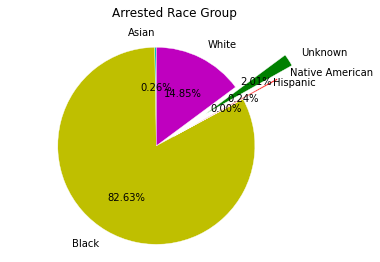

In [24]:
# Race Pie Chart
race_title = 'Asian', 'Black', 'Hispanic', 'Native American', 'Unknown', 'White'
race_val = [931, 290403, 1, 826, 7079, 52193]
colors = ['c','y', 'k','r','g','m']

# Create a piep lot 
# poping out the unknow, native American and Hispanic
# due to these portions are too small and the labels are squished together
plt.pie(race_val, labels=race_title, labeldistance=1.15, 
        wedgeprops = { 'linewidth' : 0.4, 'edgecolor' : 'white' },
        colors=colors,
        startangle=90,
        explode = (0, 0, 0.2, 0.4, 0.6, 0),
        autopct = '%1.2f%%')

plt.axis('equal')
plt.title('Arrested Race Group\n')

plt.show();

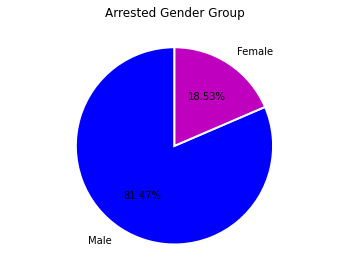

In [25]:
# Subgroup Gender
gender_group = marginal['Gender']
female = marginal[gender_group == 'F']
male = marginal[gender_group =='M']

# Gender Pie Chart
gender_title = 'Male', 'Female'
gender_val = [len(male), len(female)]
colors = ['b','m']

plt.pie(gender_val, labels=gender_title, labeldistance=1.15,
        wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },
        colors=colors,
        startangle=90,
        explode = (0, 0),
        autopct = '%1.2f%%')

plt.axis('equal')
plt.title('Arrested Gender Group\n')

plt.show();

### ROC Curve

In [26]:
# target, Gender
# we want to know the prediction of male arrestees in each race
is_male = marginal['Gender']
is_male = is_male.replace('M', 1).replace('F', 0)

# drop redundent column
del marginal["Gender"]
marginal.head()

,Row ID,Age,Race,Arrest_Time,Incident_Offence,Charge_Description
171271,171272,55.0,B,2012/06/29 11:15:00+00,87NARCOTICS,CDS VIOL
346948,346949,24.0,B,2010/01/06 09:15:00+00,3KROBB RES. (UA),Unknown Charge
10906,10907,26.0,B,2015/12/16 10:30:00+00,87NARCOTICS,CDS
218363,218364,23.0,W,2014/05/12 15:00:00+00,Unknown Offense,VIOLATION OF PROBATION
341962,341963,30.0,B,2022/01/10 07:00:00+00,Unknown Offense,FAILURE TO APPEAR


In [27]:
# normalize the data
data = marginal
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in data.columns:
  if data[column_name].dtype == object:
    data[column_name] = le.fit_transform(data[column_name])
  else:
    pass
data.head()

,Row ID,Age,Race,Arrest_Time,Incident_Offence,Charge_Description
171271,171272,55.0,1,71238,154,3601
346948,346949,24.0,1,392,73,13023
10906,10907,26.0,1,157566,154,2293
218363,218364,23.0,5,123108,182,13171
341962,341963,30.0,1,245537,182,7145


In [28]:
# split data to with train data and test data with ratio 0.7:0.3
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(data, is_male, test_size = 0.3)
train_num = len(train_data)

In [29]:
log_re = LogisticRegression();
log_re.fit(train_data, train_label)
# keep probabilities for the positive outcome only
score = log_re.predict_proba(test_data)[:,1] 
log_re.coef_

array([[ 1.56679934e-06,  1.35924442e-03, -5.67392270e-05,
         1.24046474e-06,  5.85052383e-03,  1.65589235e-05]])

In [30]:
# Redo the marginal data frame since the original marginal is overwrite with the normalized data
marginal = pd.DataFrame(data=feature, columns=['Row ID', 'Age', 'Gender', 'Race', 'Arrest_Time', 'Incident_Offence', 'Charge_Description'])
# drops rows with Nan value based on the Age column
marginal.dropna(subset = ['Age'], inplace=True)

In [31]:
original_test = marginal[train_num:]
dataFrame = {'target': test_label.values,
             'score':  score,           
             'race': original_test['Race']
             }
marginal2 = pd.DataFrame(data=dataFrame, columns=['target', 'score', 'race'])
marginal2.head() 

,target,score,race
16164,1,0.819626,W
235059,1,0.839022,B
292152,1,0.740962,B
319196,1,0.825485,B
272339,1,0.744781,B


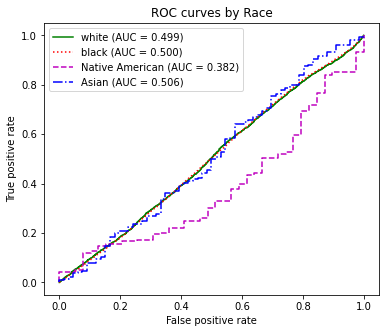

In [32]:
# ploting ROC Curves
white = marginal2[marginal2['race'] == 'W']
fpr_white, tpr_white, _ = metrics.roc_curve(white['target'], white['score'])
# geting the AUC for white group
auc_white = auc(fpr_white,tpr_white)

black = marginal2[marginal2['race'] == 'B']
fpr_black, tpr_black, _ = metrics.roc_curve(black['target'], black['score'])
auc_black = auc(fpr_black,tpr_black)

nativeAm = marginal2[marginal2['race'] == 'I']
fpr_na, tpr_na, _ = metrics.roc_curve(nativeAm['target'], nativeAm['score'])
auc_na = auc(fpr_na,tpr_na)

asian = marginal2[marginal2['race'] == 'A']
fpr_asian, tpr_asian, _ = metrics.roc_curve(asian['target'], asian['score'])
auc_asian = auc(fpr_asian,tpr_asian)


plt.figure(1, figsize=(6, 5))
plt.title('ROC curves by Race')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(fpr_white, tpr_white, label='white (AUC = %0.3f)' % auc_white, linestyle='-', color='g')
plt.plot(fpr_black, tpr_black, label='black (AUC = %0.3f)' % auc_black, linestyle=':', color='r')
plt.plot(fpr_na, tpr_na, label='Native American (AUC = %0.3f)' % auc_na, linestyle='--', color='m')
plt.plot(fpr_asian, tpr_asian, label='Asian (AUC = %0.3f)' % auc_asian, linestyle='-.', color='b')


plt.legend()
plt.show()